# Audio Feature extraction example

In this colab, we will learn how to load a wave audio file and how to extract features from the audio, using an external audio library (librosa) and with plain PyTorch

First we need to download some audio samples and extract them into colab's virtual machine. The audio samples are a mini subset of Google Speech Commands Dataset v0.01 https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data

In [ ]:
import matplotlib.pyplot as plt
import librosa
import numpy as np


In [ ]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1fJb7dDbdiGNsO-zAwopDuPRP8XfBKa_u"


Downloading...
From: https://drive.google.com/uc?id=1fJb7dDbdiGNsO-zAwopDuPRP8XfBKa_u
To: /content/mini_gcommands.tar.gz
2.26MB [00:00, 146MB/s]


In [ ]:
!tar -zxvf mini_gcommands.tar.gz

mini/
mini/wow/
mini/wow/8c7c9168_nohash_0.wav
mini/wow/9a7c1f83_nohash_0.wav
mini/six/
mini/six/324210dd_nohash_2.wav
mini/six/1aeef15e_nohash_0.wav
mini/up/
mini/up/b5552931_nohash_4.wav
mini/up/27b03931_nohash_0.wav
mini/up/324210dd_nohash_1.wav
mini/up/24befdb3_nohash_3.wav
mini/up/9c06a3f3_nohash_0.wav
mini/one/
mini/one/caedb73a_nohash_0.wav
mini/one/b1114e4f_nohash_0.wav
mini/one/c0e0f834_nohash_0.wav
mini/one/71aa5b54_nohash_0.wav
mini/one/095847e4_nohash_0.wav
mini/three/
mini/three/cd7f8c1b_nohash_2.wav
mini/three/9db2bfe9_nohash_0.wav
mini/three/0132a06d_nohash_3.wav
mini/three/59c3a7f2_nohash_0.wav
mini/three/7e1054e7_nohash_0.wav
mini/three/65f2531f_nohash_1.wav
mini/dog/
mini/dog/4b39347d_nohash_1.wav
mini/right/
mini/right/25132942_nohash_2.wav
mini/right/ab5ae445_nohash_0.wav
mini/right/af30314d_nohash_0.wav
mini/five/
mini/five/56cd307a_nohash_0.wav
mini/two/
mini/two/a42a88ff_nohash_1.wav
mini/two/122c5aa7_nohash_4.wav
mini/two/e7ebf59c_nohash_0.wav
mini/two/87728a88_

# Let's load and examine an audio file

It is possible to load the audio using librosa or wavfile from scipy. Be careful because the range of the audio using librosa is [-1.0, 1.0] but the range using scipy.wavefile is [−32768, 32767] or [-2^15, 2^15-1], so normalization  by 2^16 is needed.


In [ ]:
#load with librosa
#y, sfr = librosa.load('mini/stop/57376a4c_nohash_2.wav')


#load with scipy, need to normalize the range to [-1.0, 1.0) by dividing by 2^15
from scipy.io import wavfile

#sfr is the original sampling rate of the audio
#y is a numpy array containing the audio
sfr, y = wavfile.read('mini/stop/57376a4c_nohash_2.wav')
y = y / 2**15
print("Sampling frequency", sfr)
print("Audio samples", y.shape)
print("Audio duration", y.shape[0]/sfr, "second(s)")
np.mean(y)

Sampling frequency 16000
Audio samples (16000,)
Audio duration 1.0 second(s)


1.0223388671875e-06

In [ ]:
#Code to embed the audio into colab
import IPython
import librosa.display
IPython.display.Audio("mini/stop/57376a4c_nohash_2.wav")


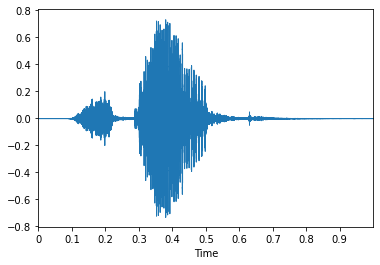

In [ ]:
# Code to display the audio wave
librosa.display.waveplot(y, sr=sfr)

# Compute the Shot Term Fourier Transform (STFT) using librosa

Documentation of librosa.stft
https://librosa.github.io/librosa/generated/librosa.core.stft.html

and librosa.display.specshow to display a spectrogram:
https://librosa.github.io/librosa/generated/librosa.display.specshow.html

First we define all the default parameters for computing the stft that were described in the slides and the compute the Spectrogram D

The shape of D is n_fft//2 + 1

In [ ]:
window_stride=0.01 #One frame every 10 ms
window_size=0.020 #Window size of 20 ms
window_type='hamming'
win_length = int(sfr * window_size) #320
hop_length = int(sfr * window_stride) #160
n_fft = 512
lowfreq = 20
highfreq = sfr/2 - 400

D = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, 
                        win_length=win_length, window=window_type, center=True))
print("D shape", D.shape)
print("Number of windows usinf center=True -> (y.shape[0] / hop_length +1) = ", y.shape[0] / hop_length +1)

D shape (257, 101)
Number of windows usinf center=True -> (y.shape[0] / hop_length +1) =  101.0


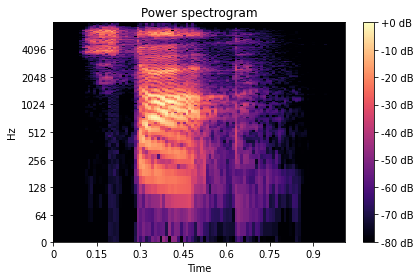

In [ ]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(D,
                                               ref=np.max),
                          y_axis='log', x_axis='time', sr=sfr, hop_length=hop_length)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()

# Computation of Mel-Filterbanks and MFCCs using librosa

In [ ]:

S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window_type, center=True)
D = np.abs(S)
melFB = librosa.feature.melspectrogram(S=D, sr=sfr, n_mels=40, fmin=lowfreq, fmax=highfreq, norm=None)
mfcc_default = librosa.feature.mfcc(y=y, sr=sfr, n_mfcc=13)
mfcc = librosa.feature.mfcc(S=librosa.power_to_db(D), n_mfcc=13)

In [ ]:
print(D.shape)
print(melFB.shape)
print(mfcc_default.shape)
print(mfcc.shape)

(257, 101)
(40, 101)
(13, 32)
(13, 101)


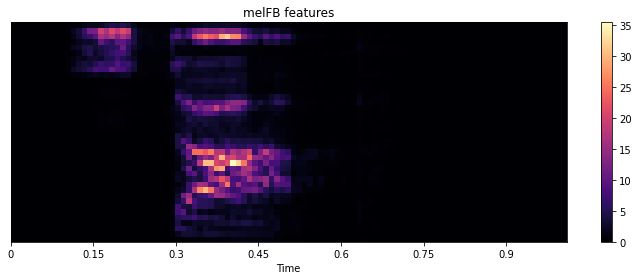

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(melFB, x_axis='time',sr=sfr, hop_length=hop_length, fmin=lowfreq, fmax=highfreq)
plt.colorbar()
plt.title('melFB features')
plt.tight_layout()

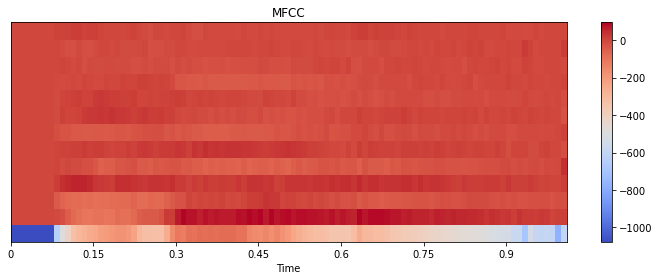

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time',sr=sfr, hop_length=hop_length, fmin=lowfreq, fmax=highfreq)
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [ ]:
def getParams(wavefile, window_stride=0.01, window_size=0.02, window_type='hamming', nfft=512):
  y, sfr = librosa.load(wavefile)
  win_length = int(sfr * window_size)
  hop_length = int(sfr * window_stride)
  lowfreq = 20
  highfreq = sfr/2 - 400
  S = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window_type, center=False)
  D = np.abs(S)
  melFB = librosa.feature.melspectrogram(S=D, sr=sfr, n_mels=40, fmin=lowfreq, fmax=highfreq, norm=None)
  #mfcc = librosa.feature.mfcc(y=y, sr=sfr, n_mfcc=40)
  mfcc = librosa.feature.mfcc(S=librosa.power_to_db(D), n_mfcc=13)
  return [D, melFB, mfcc]
    

In [ ]:
def plot_params(params, classes, title='MFCC', nrows=2, ncols=5):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=False,
                             sharey=True, figsize=(20,5))
    fig.suptitle(title, size=16)
    i = 0
    for x in range(nrows):
        for y in range(ncols):
            axes[x,y].set_title(classes[i])
            axes[x,y].imshow(params[i],
                    cmap='hot', interpolation='nearest')
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

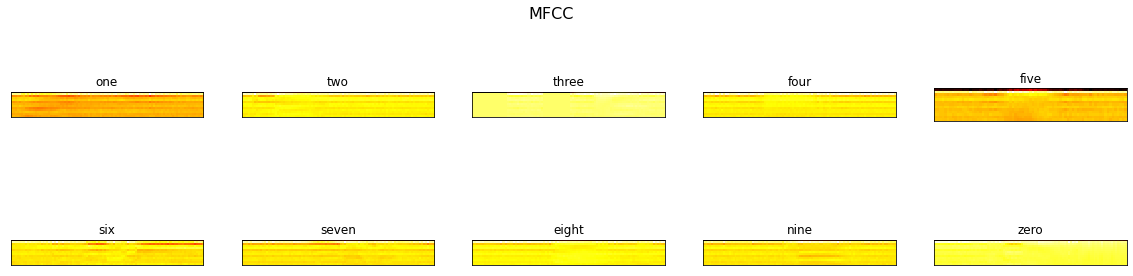

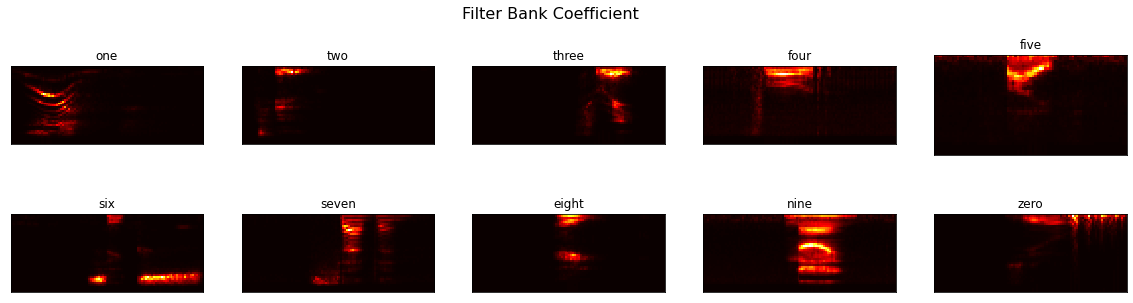

In [ ]:
classes = ['one', 'two','three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero']
wavfiles = ['mini/one/b1114e4f_nohash_0.wav',
            'mini/two/122c5aa7_nohash_4.wav',
            'mini/three/9db2bfe9_nohash_0.wav',
            'mini/four/cc6bae0d_nohash_0.wav',
            'mini/five/56cd307a_nohash_0.wav',
            'mini/six/324210dd_nohash_2.wav',
            'mini/seven/cc592808_nohash_0.wav',
            'mini/eight/c90c0105_nohash_0.wav',
            'mini/nine/c0fb6812_nohash_3.wav',
            'mini/zero/c1d39ce8_nohash_3.wav']
filterbanks=[]
mfccs = []
for w in wavfiles:
  _, fb, mfcc = getParams(w)
  filterbanks.append(fb)
  mfccs.append(mfcc)
  
plot_params(mfccs, classes)
plot_params(filterbanks, classes, title='Filter Bank Coefficient')

# STFT using PyTorch

Computing the STFT inside PyTorch has many advantages:
* GPU paralelization
* Gradient computation:
** We can use STFT as a normal layer in PyTorch

In [ ]:
import torch
import torch.nn as nn

class MelScale(object):
    """This turns a normal STFT into a mel frequency STFT, using a conversion
       matrix.  This uses triangular filter banks.
    Args:
        n_mels (int): number of mel bins
        sr (int): sample rate of audio signal
        f_max (float, optional): maximum frequency. default: `sr` // 2
        f_min (float): minimum frequency. default: 0
        n_stft (int, optional): number of filter banks from stft. Calculated from first input
            if `None` is given.  See `n_fft` in `Spectrogram`.
    """
    def __init__(self, n_mels=128, sr=16000, f_max=None, f_min=0., n_stft=None):
        self.n_mels = n_mels
        self.sr = sr
        self.f_max = f_max if f_max is not None else sr // 2
        self.f_min = f_min
        self.fb = self._create_fb_matrix(n_stft) if n_stft is not None else n_stft

    def __call__(self, spec_f):
        if self.fb is None:
            self.fb = self._create_fb_matrix(spec_f.size(2)).to(spec_f.device)
        else:
            # need to ensure same device for dot product
            self.fb = self.fb.to(spec_f.device)
        spec_m = torch.matmul(spec_f, self.fb)  # (c, l, n_fft) dot (n_fft, n_mels) -> (c, l, n_mels)
        return spec_m

    def _create_fb_matrix(self, n_stft):
        """ Create a frequency bin conversion matrix.
        Args:
            n_stft (int): number of filter banks from spectrogram
        """

        # get stft freq bins
        stft_freqs = torch.linspace(self.f_min, self.f_max, n_stft)
        # calculate mel freq bins
        m_min = 0. if self.f_min == 0 else self._hertz_to_mel(self.f_min)
        m_max = self._hertz_to_mel(self.f_max)
        m_pts = torch.linspace(m_min, m_max, self.n_mels + 2)
        f_pts = self._mel_to_hertz(m_pts)
        # calculate the difference between each mel point and each stft freq point in hertz
        f_diff = f_pts[1:] - f_pts[:-1]  # (n_mels + 1)
        slopes = f_pts.unsqueeze(0) - stft_freqs.unsqueeze(1)  # (n_stft, n_mels + 2)
        # create overlapping triangles
        z = torch.tensor(0.)
        down_slopes = (-1. * slopes[:, :-2]) / f_diff[:-1]  # (n_stft, n_mels)
        up_slopes = slopes[:, 2:] / f_diff[1:]  # (n_stft, n_mels)
        fb = torch.max(z, torch.min(down_slopes, up_slopes))
        return fb

    def _hertz_to_mel(self, f):
        return 2595. * torch.log10(torch.tensor(1.) + (f / 700.))

    def _mel_to_hertz(self, mel):
        return 700. * (10**(mel / 2595.) - 1.)
      
class MelSpectrogram(object):
    def __init__(self, n_mels = 40, sfr=16000):
        
        self.sfr = sfr
        self.window_stride=0.01
        self.window_size=0.02
        self.n_fft=512
        self.n_mels=n_mels
        
        self.win_length = int(self.sfr * self.window_size)
        self.hop_length = int(self.sfr * self.window_stride)
        self.lowfreq = 20
        self.highfreq = self.sfr/2 - 400
        self.window = torch.hamming_window(self.win_length)
        
        self.mel = MelScale(n_mels=self.n_mels, sr=self.sfr, f_max=self.highfreq, f_min=self.lowfreq)
        self.norm = nn.InstanceNorm2d(1)

    def __call__(self, x):
        
        x = x.squeeze(1)
        spec_f = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length, 
                    win_length=self.win_length, 
                    window=self.window,
                    center=True,
                    normalized=False, onesided=True,
                    pad_mode='reflect'
                   )
        spec_f = spec_f.pow(2).sum(-1)
        x = self.mel(spec_f.transpose(1,2)).transpose(1,2)
        x = torch.log(x+0.0001)
        x = x.unsqueeze(1)
        #x = self.norm(x)
        return x
      
      
    def plot_sample(self, fbank, index):
        librosa.display.specshow(fbank[index,:,:,:].view(self.n_mels,-1).numpy(),
                          y_axis='mel', x_axis='time',sr=self.sfr, fmax=self.highfreq, hop_length=self.hop_length)
        plt.title('Mel spectrogram')
        plt.colorbar(format='%+2.0f dB')
        plt.tight_layout()
    

/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  normalized, onesided, return_complex)
/usr/local/lib/python3.7/dist-packages/torch/functional.py:516: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  normalized, onesided, return_complex)


D.shape torch.Size([1, 1, 40, 101])


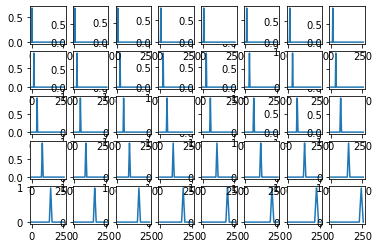

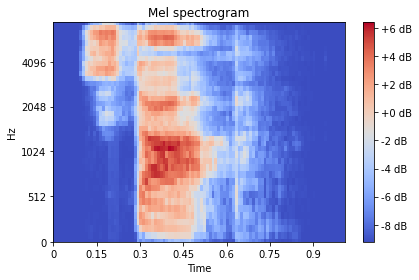

In [ ]:
mel_extractor = MelSpectrogram()

# MelSpectrogram expects a tensor of dimensions: batch_size, num_channels, audio_samples
audio_tensor = torch.FloatTensor(y)
audio_tensor = audio_tensor.view(1,1,16000)
D = mel_extractor(audio_tensor)
print("D.shape", D.shape)

plt.figure()
for i in range(5):
    for j in range(8):
        plt.subplot(5, 8, i+j*5+1)
        plt.plot(mel_extractor.mel.fb[:,i+j*5].numpy())

plt.figure()
mel_extractor.plot_sample(D, index=0)